In [1]:
# Script to calculate generality and  application data
# Generality: how diverse is the impact of a patent
# This is done by calculating the herfindal index of citing patents

In [2]:
# as of Jan 13th, 2020, there are 496495 patents with nans (from 7 million patents)

# Jan 13th, 2019
# Script is running but there are two major issues
# - there should not exist generality > 1 , so there is an error in calculation
# - too many NANs (about 400k), but I will tackle this issue in 'too_many_nans.ipynb'

# to tackle the first problem, I'll begin by creating a subset of the database
# to do that, I'll use USPTO classification system

In [3]:
# Trying to save memory is leading to a small nightmare 
# I am postponing the use of dask modules

In [4]:
import sys
sys.path.append('/home/rkogeyam/scripts/')
from sampler import sampler

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import dask.dataframe as dd

In [5]:
# wipo_horiz.csv
# from wipo_horiz.ipynb
# Original WIPO classification reshaped
# patent_id:    patent number
# field_id_n :  'n' is the WIPO class

# uspatentcitation.tsv
# uuid:         unique id
# patent_id:    patent number
# citation_id:  identifying number of patent to which select patent cites
# date:         date select patent (patent_id) cites patent (citation_id)
# name:         name of cited record
# kind:         WIPO document kind codes 
#               (http://www.uspto.gov/learning-and-resources/support-centers/electronic-business-center/kind-codes-included-uspto-patent)	2002 and After
# country:      country cited patent was granted (always US)
# category:     who cited the patent (examiner, applicant, other etc) - 2002 and After
# sequence:     order in which this reference is cited by select patent	all


In [6]:
%matplotlib inline

In [7]:
src= '/home/rkogeyam/PATENT_CITATION/data/generality_temp.csv'
dst= '/home/rkogeyam/PATENT_CITATION/data/generality.csv'

In [8]:
%%time
df=pd.read_csv(src, usecols=['patent_id','citation_id','field_id'])

CPU times: user 47.2 s, sys: 4.72 s, total: 51.9 s
Wall time: 51.9 s


In [9]:
df.shape

(82598452, 3)

In [10]:
df = pd.get_dummies(df, columns=['field_id'])

In [11]:
df.head()

,patent_id,citation_id,field_id_1,field_id_2,field_id_3,field_id_4,field_id_5,field_id_6,field_id_7,field_id_8,...,field_id_26,field_id_27,field_id_28,field_id_29,field_id_30,field_id_31,field_id_32,field_id_33,field_id_34,field_id_35
0,3930271,2379430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3930271,2782422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3930272,2560109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3930272,2545289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3930272,1549144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
%%time
# group on citation_id - thus adding all patents citing one receiver (citation_id)
# thus this is generality
# its the impact of a given patent

# the index is equivalent to 1 - herfindal
# this way, the closer to 1, the more general

# the denominator is total citations squared
# should be easy to check with citation values

total_citation=df.groupby('citation_id').count().iloc[:,0]
total_citation=np.square(total_citation)

CPU times: user 1min 23s, sys: 8.15 s, total: 1min 31s
Wall time: 1min 31s


In [13]:
total_citation.describe()

count    6.555151e+06
mean     1.105135e+03
std      2.118908e+04
min      1.000000e+00
25%      4.000000e+00
50%      2.500000e+01
75%      1.440000e+02
max      1.518661e+07
Name: patent_id, dtype: float64

In [14]:
%%time

# the numerator is the sum of the squares of citations in each class

df=df.groupby('citation_id').sum().fillna(0) #in theory, I would not need fillna, check later

CPU times: user 1min 33s, sys: 7.48 s, total: 1min 41s
Wall time: 1min 41s


In [15]:
df.drop('patent_id', inplace=True, axis=1)

In [16]:
df.head()

,field_id_1,field_id_2,field_id_3,field_id_4,field_id_5,field_id_6,field_id_7,field_id_8,field_id_9,field_id_10,...,field_id_26,field_id_27,field_id_28,field_id_29,field_id_30,field_id_31,field_id_32,field_id_33,field_id_34,field_id_35
citation_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000482,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# df=df.drop(['Unnamed: 0', 'sequence', 'patent_id_raw'], axis=1)

In [18]:
df_squared=np.square(df) #element-wise squaring
df_squared=df_squared.sum(axis='columns') #sum all columns, per row

In [19]:
df_squared.describe()

count    6.555151e+06
mean     7.165019e+02
std      1.388037e+04
min      1.000000e+00
25%      2.000000e+00
50%      1.600000e+01
75%      8.300000e+01
max      9.371377e+06
dtype: float64

In [20]:
# df=total_citation.join(df_squared, how='left')  # join only for dataframe
df2=pd.concat([df_squared, total_citation], axis=1)

In [21]:
df2.columns=['df_squared', 'total_citation']

In [22]:
# df.sort_values('total_citation', ascending=False)

In [23]:
%%time
#herfindal 

df2['herfindal']=df2['df_squared']/df2['total_citation'] #its a measure of concentration

df2['generality']=1-df2['herfindal'] # as defined in Hall et al, 2001

CPU times: user 70 ms, sys: 2 ms, total: 72 ms
Wall time: 72.4 ms


In [24]:
df2.describe()

,df_squared,total_citation,herfindal,generality
count,6.555151e+06,6.555151e+06,6.555151e+06,6.555151e+06
mean,7.165019e+02,1.105135e+03,7.466114e-01,2.533886e-01
std,1.388037e+04,2.118908e+04,2.652133e-01,2.652133e-01
min,1.000000e+00,1.000000e+00,7.640412e-02,0.000000e+00
25%,2.000000e+00,4.000000e+00,5.000000e-01,0.000000e+00
50%,1.600000e+01,2.500000e+01,8.116343e-01,1.883657e-01
75%,8.300000e+01,1.440000e+02,1.000000e+00,5.000000e-01
max,9.371377e+06,1.518661e+07,1.000000e+00,9.235959e-01


In [25]:
#select more negative values of generality (it should be between 0 and 1)
# df.sort_values('total_citation', ascending=False)

In [26]:
# total_citation.reset_index().set_index('citation_id')
# total_citation.reset_index()

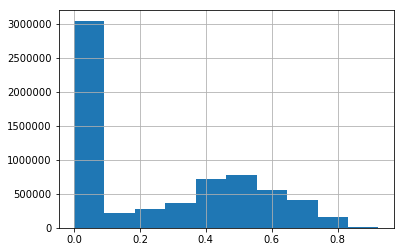

In [27]:
#merge previous selection to wipo dataset
df2['generality'].hist()

In [28]:
df2.to_csv(dst)

In [29]:
# search for errors

# df_search=df2.sort_values('output', ascending=False).head(100)
# df=df_search.join(df, how='inner') 
# pd.set_option('display.max_columns', 500)
# df

In [30]:
# list of patents NaN attributes

# df[df.isnull().any(axis=1)]['citation_id'] 

In [31]:
#as of Jan 6th, 2020
#check if calculation is right
#create the generality indicator